# The Kidney Exchange Problem

The Kidney Exchange Problem involves a set of patients and donors, where each patient is incompatible with their own donor, but potentially compatible with another donor. The goal is to find a maximum size set of mutually compatible pairs. In this notebook, we will model, solve and plot results for the KEP using SeaPearl.

<img src="img/kep.png" alt="Kep" style="width:700px; height:350px;">

## Setup

We will begin by setting up the necessary packages.

In [1]:
using Revise
using Pkg
Pkg.activate("../../../")
using SeaPearl

  Activating project at `c:\Users\leobo\Desktop\École\Poly\SeaPearl\SeaPearlZoo.jl`


## Problem formulation

The instances have the following format:
```
8 0.2
2 3
1 6
1 4 7
2
2
5
8
3
```
The first line contains the number of patients and the probability of compatibility. The following lines contain the donor numbers for each patient. The first patient is compatible with donors 2 and 3, the second patient is compatible with donors 1 and 6, etc.

## Parsing the Instances

We will now build utilities to parse the instances. In addition to the utility function to read the instance and load it, we will also be using a function to reduce the instances. This will be done with the `reduce_instance` function. This function will take an instance and remove all patients that are incompatible with all other patients. This will reduce the size of the instance and make it easier to solve.

In [5]:
"""KidneyExchangeInputData(numberOfPairs::Int, density::Float16, compatibilities::Vector{Vector{Int}})

Input to the Kidney Exchange Problem
"""
struct KidneyExchangeInputData
    numberOfPairs::Int
    density::Float16
    compatibilities::Vector{Vector{Int}}
end

"""
parseInput(filename::String)

Return an KidneyExchangeInputData with the following fields:
- numberOfPairs::Int                 -> number of donor-patient pairs
- density::Float16                   -> probability of compatibility between 2 pairs (density ∈ [0,1])
- compabilities::Vector{Vector{Int}} -> v[i] contains the pairs that can give a kidney to pair i  

# Arguments
- `filename`: path to the file containing the compatibilities between pairs
"""
function parseKidneyExchangeInput(filename::String)
    raw_input = nothing
    open(filename, "r") do openedFile
        raw_input = read(openedFile, String)
    end
    lines = split(raw_input, '\n')
    firstLine = split(lines[1], ' ')

    numberOfPairs = parse(Int, firstLine[1])
    density = parse(Float16, firstLine[2])
    compabilities = Vector{Vector{Int}}(undef, numberOfPairs)

    for i = 2:numberOfPairs+1
        if isempty(lines[i])
            #Edge case: pair i can't receive any kidney
            compabilities[i-1] = []
        else
            line = split(lines[i], ' ')
            compabilities[i-1] = map(x -> parse(Int, x), line)
        end
    end
    return KidneyExchangeInputData(numberOfPairs, density, compabilities)
end

"""
reduce_instance(inputData)

Try to remove recursively from compatibilities the pairs that can't receive nor give any kidney
Create a vector (pairsEquivalence) to record the equivalence between the original instance and the reduced version
### Args
- inputData::KidneyExchangeInputData

### Output
- canReduce: bool to know if the instance is reductible
- pairsEquivalence: vector to record the equivalence between the original instance and the reduced version 
- c: reduced version of the vector compatibilities
"""
function reduce_instance(inputData::KidneyExchangeInputData)
    num_pairs = inputData.numberOfPairs
    compatibilities = inputData.compatibilities
    canReduce = true
    current_num_pairs = num_pairs

    #Remove recursively from vectors in compatibilities the pairs that can't receive nor give any kidney
    while canReduce
        flattened_compatibilities = reduce(vcat, compatibilities)
        usefulPairs = [i for i in 1:num_pairs if i in flattened_compatibilities && compatibilities[i] != []]
        if length(usefulPairs) < current_num_pairs
            compatibilities = [filter(e -> e in usefulPairs, list) for list in compatibilities]
            current_num_pairs = length(usefulPairs)
        else
            canReduce = false
        end
    end

    if num_pairs != current_num_pairs # problem has been reduced
        pairsEquivalence = [] # Equivalence between the original instance and the reduced version
        for i in 1:num_pairs
            if !isempty(compatibilities[i])
                push!(pairsEquivalence, i)
            end
        end
        compatibilities = filter(e -> !isempty(e), compatibilities) #Remove from compatibilities the isolated pairs

        for i in 1:length(compatibilities) #Update compatibilities using pairsEquivalence
            compatibilities[i] = map(e -> findfirst(x -> x == e, pairsEquivalence), compatibilities[i])
        end
        println("Instance reduction: original size " * string(n) * ", reduced size " * string(current_num_pairs))
        return true, pairsEquivalence, compatibilities
    else
        println("Irreducible instance")
        return false, nothing, nothing
    end
end

reduce_instance

In [14]:
kep_instance = parseKidneyExchangeInput("./data/kep_8_0.2")
canReduce, pairsEquivalence, reduced_compatibilities = reduce_instance(kep_instance)

Irreducible instance


(false, nothing, nothing)

## Modeling the Problem

We will now build a model for the KEP.

In [16]:
compatibilities = kep_instance.compatibilities
trailer = SeaPearl.Trailer()
model = SeaPearl.CPModel(trailer)

### Attempting to reduce the instance ### 
if canReduce
    model.adhocInfo = pairsEquivalence
    compatibilities = reduced_compatibilities
end
num_pairs = length(compatibilities)

# =========VARIABLES=========
#x[i, j] = 1 => pair i receive a kidney from pair j
#x[i, j] = 0 => pair i do not receive a kidney from pair j
x = Matrix{SeaPearl.AbstractIntVar}(undef, num_pairs, num_pairs)

#minus_x = x * -1
#Usefull to check with SumToZero that for each pair: give a kidney <=> receive a kidney
minus_x = Matrix{SeaPearl.AbstractIntVar}(undef, num_pairs, num_pairs)

for i = 1:num_pairs
    for j = 1:num_pairs
        if j ∈ compatibilities[i]
            x[i, j] = SeaPearl.IntVar(0, 1, "x_" * string(i) * "_" * string(j), model.trailer)
            SeaPearl.addVariable!(model, x[i, j]; branchable=true)
            minus_x[i, j] = SeaPearl.IntVarViewOpposite(x[i, j], "-x_" * string(i) * "_" * string(j))
        else
            #force x[i, j] = 0 as j ∉ compatibilities[i]
            x[i, j] = SeaPearl.IntVar(0, 0, "x_" * string(i) * "_" * string(j), model.trailer)
            SeaPearl.addVariable!(model, x[i, j]; branchable=false)
            minus_x[i, j] = SeaPearl.IntVarViewOpposite(x[i, j], "-x_" * string(i) * "_" * string(j))
        end
    end
end

# =========CONSTRAINTS=========
for i = 1:num_pairs
    SeaPearl.addConstraint!(model, SeaPearl.SumLessThan(x[i, :], 1, trailer)) #Check that any pair receives more than 1 kidney
    SeaPearl.addConstraint!(model, SeaPearl.SumLessThan(x[:, i], 1, trailer)) #Check that any pair gives more than 1 kidney
    SeaPearl.addConstraint!(model, SeaPearl.SumToZero(hcat(x[:, i], minus_x[i, :]), trailer)) #Check that for each pair: give a kidney <=> receive a kidney
end

# =========OBJECTIVE=========
minusNumberOfExchanges = SeaPearl.IntVar(-num_pairs, 0, "minusNumberOfExchanges", trailer) # SeaPearl minimizes the objective, so we min the negative objective 
SeaPearl.addVariable!(model, minusNumberOfExchanges; branchable=false)
vars = SeaPearl.AbstractIntVar[]

for i in 1:num_pairs
    vars = cat(vars, x[i, :]; dims=1)
end
push!(vars, minusNumberOfExchanges)

#minusNumberOfExchanges will take the necessary value to compensate the occurences of "1" in x
objective = SeaPearl.SumToZero(vars, trailer)
SeaPearl.addConstraint!(model, objective)
SeaPearl.addObjective!(model, minusNumberOfExchanges)

model.limit.searchingTime = 120 # 2 minutes

Int64[]

## Solving the Problem
Now that the model is built, we will solve it!

In [17]:
@time SeaPearl.solve!(model; variableHeuristic=SeaPearl.MinDomainVariableSelection{false}(), valueSelection=SeaPearl.BasicHeuristic())

  5.150511 seconds (8.75 M allocations: 481.877 MiB, 3.67% gc time, 99.75% compilation time)


:Optimal

## Plotting the Results

We will now plot the results of the KEP, beginning by getting the best solution from the model.

In [60]:
function get_top_solution(model::SeaPearl.CPModel)
    top_solution = nothing
    top_length = nothing
    for solution in model.statistics.solutions
        if !isnothing(solution)
            solution_length = get_solution_sum(solution)
            if isnothing(top_solution)
                top_solution = solution
                top_length = solution_length
            elseif solution_length > top_length
                top_solution = solution
                top_length = solution_length
            end
        end
    end
    return top_solution
end

function get_solution_sum(solution::Dict)
    current_sum = 0
    for (key, value) in solution
        if value == 1
            current_sum += 1
        end
    end
    return current_sum
end

get_solution_sum (generic function with 1 method)

In [61]:
solution = get_top_solution(model)

6

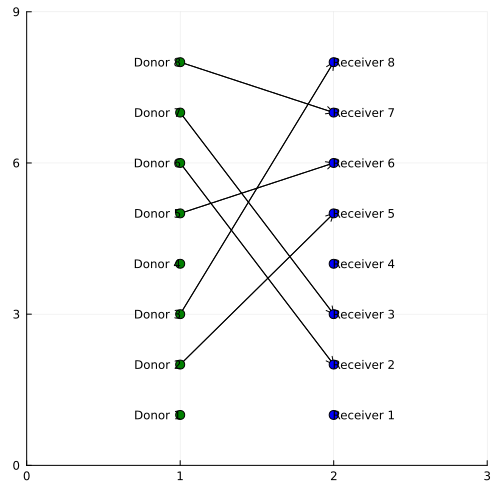

In [110]:
using Plots

function get_pairs(solution::Dict)
    donation_pairs = []
    for (key, value) in solution
        if occursin("minus", key)
            continue
        end
        receiver = parse(Int, split(key, "_")[2])
        donor = parse(Int, split(key, "_")[3])
        if value == 1
            push!(donation_pairs, [donor, receiver])
        end
    end
    return donation_pairs
end
# Find all unique receivers and donors
num_pairs = length(kep_instance.compatibilities)

# Names for labeling vertices
donor_names = ["Donor $i" for i in 1:num_pairs]
receiver_names = ["Receiver $i" for i in 1:num_pairs]

# Create layout manually
layout_donors = [(1, i) for i in 1:num_pairs]
layout_receivers = [(2, i) for i in 1:num_pairs]

# Initialize plot with specified size
plot(size=(500, 500), legend=false, xlim=(0, 3), ylim=(0, num_pairs + 1))

donation_pairs = get_pairs(solution)
for pair in donation_pairs
    plot!([1, 2], pair, arrow=true, color=:black, lw=1)
end

# Add vertices to plot
scatter!(first.(layout_donors), last.(layout_donors), markersize=5, color=:green, label="Donors")
scatter!(first.(layout_receivers), last.(layout_receivers), markersize=5, color=:blue, label="Receivers")

# Add labels to vertices
for (x, y) in layout_donors
    annotate!(x, y, text(donor_names[y], 8, :right))  # Change alignment to right for donors
end
for (x, y) in layout_receivers
    annotate!(x, y, text(receiver_names[y], 8, :left))  # Change alignment to left for receivers
end

# Show the plot
p = plot!()  # assign plot to variable 'p'
display(p)  # display the plot
